In [10]:
import numpy as np
import torch 
from torchvision import datasets, transforms
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline

In [12]:
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('DHlab'))))
import HHS.model
import torchOp

In [17]:
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import HHS.model

In [16]:
model = HHS.model.FCN_Leakey(10, False)
model.load_state_dict(torch.load('../result/2024-04-17 11:49:00.007987_0418_2439_test_10_0.002/2024-04-17 11:49:00.007987_0418_2439_test_10_0.002'))
model.eval()
print('')

In [29]:
warnings.filterwarnings('ignore')


class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        t = torch.Tensor([0.5]).cuda()  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

def binary_sim(out, z=2e-3):
    binary = SignFunction.apply(out)
    sim = tt.simulate(binary, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return binary, res
    

class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(512)
        self.random_crop = torchvision.transforms.RandomCrop((512, 512))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray=True)
        if self.isTrain:
            target = self.random_crop(target)
        else:
            target = self.center_crop(target)
        return target.unsqueeze(0)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

# load data
batch_size = 1
target_dir = '../dataset/DIV2K/DIV2K_train_HR/'
valid_dir = '../dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [19]:
model = model.cuda()

In [20]:
criterion = F.mse_loss

In [27]:
target = train_dataset[0].unsqueeze(0)
inputs = train_dataset[0].unsqueeze(0)
# target.shape

In [28]:
hessian_comp = hessian(model, criterion, data=(inputs, target), cuda=True)

In [25]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

In [26]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

In [43]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams1 = np.linspace(-5, 1, 41).astype(np.float32)
lams2 = np.linspace(-1, 5, 41).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb1 = HHS.model.FCN_Leakey(10, False)
model_perb1.load_state_dict(torch.load('../result/2024-04-17 11:49:00.007987_0418_2439_test_10_0.002/2024-04-17 11:49:00.007987_0418_2439_test_10_0.002'))
model_perb1.eval()
model_perb1 = model_perb1.cuda()

model_perb2 = HHS.model.FCN_Leakey(10, False)
model_perb2.load_state_dict(torch.load('../result/2024-04-17 11:49:00.007987_0418_2439_test_10_0.002/2024-04-17 11:49:00.007987_0418_2439_test_10_0.002'))
model_perb2.eval()
model_perb2 = model_perb2.cuda()


for lam1 in lams1:
    for lam2 in lams2:
        model_perb1 = get_params(model, model_perb1, top_eigenvector[0], lam1)
        model_perb2 = get_params(model_perb1, model_perb2, top_eigenvector[1], lam2)
        out = model_perb2(inputs)
        binary, res = binary_sim(out)
        loss_list.append((lam1, lam2, criterion(res, target).item()))   

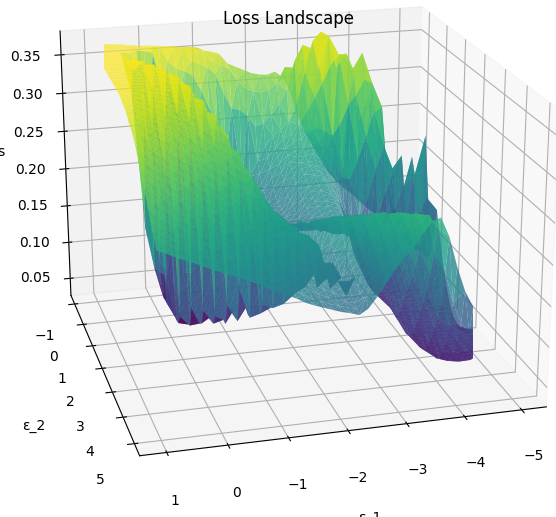

In [55]:
loss_list = np.array(loss_list)
                         
fig = plt.figure()
landscape = fig.add_subplot(projection = '3d')
landscape.plot_trisurf((loss_list[:,0]), (loss_list[:,1]), loss_list[:,2],alpha=0.8, cmap='viridis')
                       #cmap=cm.autumn, #cmamp = 'hot')


landscape.set_title('Loss Landscape')
landscape.set_xlabel('ε_1')
landscape.set_ylabel('ε_2')
landscape.set_zlabel('Loss')
landscape.view_init(20, 75)
#landscape.view_init(elev=15, azim=75)
landscape.dist = 6
plt.show()